In [38]:
import numpy as np
import pandas as pd
import nose.tools as nt
import seaborn as sns
import matplotlib.pyplot as plt

import regreg.api as rr

from selectinf.randomized.lasso import (lasso, split_lasso)
from selectinf.randomized.group_lasso_query import (group_lasso,
                                 split_group_lasso)

from selectinf.base import (full_targets,
                     selected_targets,
                     debiased_targets)
from selectinf.randomized.tests.instance import (gaussian_group_instance,
                                                 logistic_group_instance,
                                                 poisson_group_instance)
from selectinf.tests.instance import (gaussian_instance,
                               logistic_instance,
                               poisson_instance,
                               cox_instance)
from selectinf.base import restricted_estimator
from scipy.optimize import minimize

In [4]:
n = 5
_selection_idx = np.zeros(n, bool)
_selection_idx[:n] = True
_selection_idx

array([ True,  True,  True,  True,  True])

In [28]:
def n_range_to_k(n,k):
    l = []
    for i in range(k):
        if i == 0:
            start = 0
            end = int(n/k)
        elif i == k-1:
            start = end
            end = n
        else:
            start = end
            end = int((i+1) * n/k)
        range_i = range(start, end)
        l.append(range_i)
    return l

In [35]:
list = n_range_to_k(2,2)

In [37]:
for i in list[1]:
    print(i)

1


In [16]:
np.array([True] * 5)

array([ True,  True,  True,  True,  True])

In [39]:
dict = {}
dict['a'] = [1,2,3,4,5,6,7]
dict['b'] = [-3,4,5,2,4,1,9]
dict_df = pd.DataFrame.from_dict(dict)

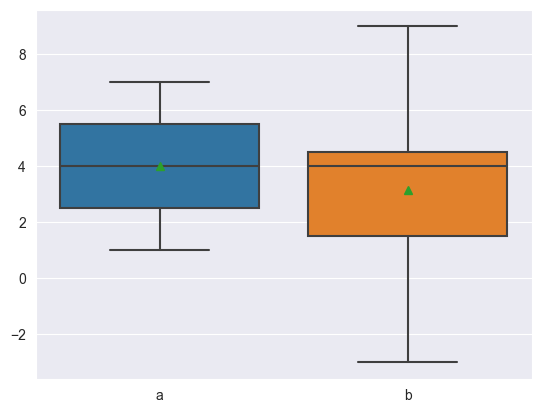

In [40]:
plot = sns.boxplot(dict_df,
                          showmeans=True,
                          orient="v")

In [45]:
M = np.matrix([[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5],[1,2,3,4,5]])
nonzero = np.array([True, False, True, False, True])
M[np.ix_(nonzero,nonzero)]

matrix([[1, 3, 5],
        [1, 3, 5],
        [1, 3, 5]])

In [4]:
def test_selected_targets_lasso(n=500,
                              p=200,
                              signal_fac=1.2,
                              s=5,
                              sigma=2,
                              rho=0.7,
                              randomizer_scale=1.,
                              full_dispersion=True,
                              level=0.90,
                              iter=100):
    """
    Compare to R randomized lasso
    """

    cover = []
    len_ = []

    for i in range(iter):

        np.random.seed(i)

        inst, const = gaussian_instance, lasso.gaussian
        signal = np.sqrt(signal_fac * 2 * np.log(p))

        while True:  # run until we get somee selection
            X, Y, beta = inst(n=n,
                              p=p,
                              signal=signal,
                              s=s,
                              equicorrelated=True,
                              rho=rho,
                              sigma=sigma,
                              random_signs=True)[:3]

            idx = np.arange(p)
            sigmaX = rho ** np.abs(np.subtract.outer(idx, idx))
            print("snr", beta.T.dot(sigmaX).dot(beta) / ((sigma ** 2.) * n))

            n, p = X.shape

            sigma_ = np.std(Y)
            W = 0.8 * np.ones(X.shape[1]) * np.sqrt(2 * np.log(p)) * sigma_

            conv = const(X,
                         Y,
                         W,
                         ridge_term=0.,
                         randomizer_scale=randomizer_scale * sigma_)

            signs = conv.fit()
            nonzero = signs != 0
            print("dimensions", n, p, nonzero.sum())

            if nonzero.sum() > 0:

                if full_dispersion:
                    dispersion = np.linalg.norm(Y - X.dot(np.linalg.pinv(X).dot(Y))) ** 2 / (n - p)
                else:
                    dispersion = np.linalg.norm(Y - X[:,nonzero].dot(np.linalg.pinv(X[:,nonzero]).dot(Y))) ** 2 / (n - nonzero.sum())

                beta_target = np.linalg.pinv(X[:, nonzero]).dot(X.dot(beta))

                conv.setup_inference(dispersion=dispersion)

                target_spec = selected_targets(conv.loglike,
                                               conv.observed_soln,
                                               dispersion=dispersion)

                result = conv.inference(target_spec,
                                        'selective_MLE',
                                        level=level)

                pval = result['pvalue']
                intervals = np.asarray(result[['lower_confidence', 'upper_confidence']])

                coverage = (beta_target > intervals[:, 0]) * (beta_target < intervals[:, 1])

                cover.extend(coverage)
                len_.extend(intervals[:, 1] - intervals[:, 0])

                print("Coverage so far ", np.mean(cover), )
                print("Lengths so far ", np.mean(len_))

                break   # Go to next iteration if we have some selection

In [3]:
df = pd.DataFrame()

In [55]:
line = [1,2,3,4]
df2 = pd.concat([df, pd.DataFrame(line), pd.DataFrame(line)], axis=0)

In [66]:
df_line = pd.concat([pd.DataFrame(["method"]), pd.DataFrame(line), pd.DataFrame(line)], axis=0)

In [88]:
df1=df_line.T
p = 4
colnames = ['method'] + ['lower_' + str(i) for i in range(p)] \
           + ['upper_' + str(i) for i in range(p)]

In [89]:
df1.columns = colnames

In [3]:
df = pd.DataFrame()

In [4]:
a = 1*np.ones(4)
b = 2*np.ones(4)
x = 5*np.ones(5)
y = 6*np.ones(5)

In [8]:
df1=pd.concat([df, pd.DataFrame(a), pd.DataFrame(b)], axis=1)
df2=pd.concat([df1, pd.concat([pd.DataFrame(x), pd.DataFrame(y)], axis=1)], axis=0)

In [41]:
dfxx=pd.DataFrame(["a"] * 5)

In [40]:
low = np.array([-1,2,3,-4,1])
up = low + [2, 1, 1, 2, 1]

In [42]:
dfxx

,0
0,a
1,a
2,a
3,a
4,a


In [38]:
a = low > 0

In [39]:
b = up < 0

In [41]:
a

array([False,  True,  True, False,  True])

In [42]:
b

array([False, False, False,  True, False])

In [37]:
a + b

array([False,  True,  True,  True,  True])

In [36]:
(a + b) != 0

array([False,  True,  True,  True,  True])

In [43]:
a.sum()

3

In [52]:
beta = np.array([0, 1, 1, 1, 1])

In [53]:
def calculate_F1_score(beta_true, conf_low, conf_up):
    nonzero = (beta_true != 0)
    print("nonzero:", nonzero)
    # lower bound > 0 or upper bound < 0
    interval_selection = ((0 < conf_low) + (0 > conf_up)) != 0
    print("interval_selection:", interval_selection)
    # precision & recall
    precision = (nonzero * interval_selection).sum() / interval_selection.sum()
    print("intersection:", nonzero * interval_selection)
    recall = (nonzero * interval_selection).sum() / nonzero.sum()

    return 2*precision*recall/(precision + recall)

In [54]:
calculate_F1_score(beta, low, up)

nonzero: [False  True  True  True  True]
interval_selection: [False  True  True  True  True]
intersection: [False  True  True  True  True]


1.0

In [5]:
A = 1

In [6]:
A is not None

True